<a href="https://colab.research.google.com/github/ramtin2080/Distributed-Random-Forests/blob/main/Distributed_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Distributed Random Forests on Adult income dataset

Prediction task is to determine whether a person makes over 50K a year.
ِDataset link: 

http://archive.ics.uci.edu/ml/datasets/Adult
https://www.kaggle.com/wenruliu/adult-income-dataset

In [ ]:
import pandas as pd
import numpy as np

#Read the dataset and split it into 100 parts
dfs = np.array_split(pd.get_dummies(pd.read_csv("adult.csv"),drop_first=True),100)

We test on a single node first:

In [ ]:

df = dfs[-1]
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass _ Federal-gov,workclass _ Local-gov,workclass _ Never-worked,workclass _ Private,workclass _ Self-emp-inc,workclass _ Self-emp-not-inc,workclass _ State-gov,workclass _ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,...,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
32236,26,323044,10,0,0,45,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32237,34,90415,11,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32238,47,294913,15,99999,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
32239,36,127573,9,0,0,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32240,21,180190,11,0,0,46,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32557,40,154374,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
32558,58,151910,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32559,22,201490,9,0,0,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

est = RandomForestClassifier(n_estimators=4,random_state=0)
est.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Metrics on a single node



In [ ]:
est.score(X_test, y_test)

0.8

In [ ]:
from sklearn.metrics import classification_report
y_pred = est.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88        49
           1       0.80      0.25      0.38        16

    accuracy                           0.80        65
   macro avg       0.80      0.61      0.63        65
weighted avg       0.80      0.80      0.76        65



A function to fit the dataset over estimators

In [ ]:
def fit(df):
    d_est = RandomForestClassifier(n_estimators=3,random_state=0)
    d_est.fit(df.drop("income_ >50K",axis=1), df["income_ >50K"])
    return d_est

train = dfs[:-1]
test = dfs[-1]

In [ ]:
estimators = []
for i in range(len(train)):
  estimators.append(fit(train[i]))

In [ ]:
def predict(d_est, df):
    return d_est.predict(df.drop("income_ >50K",axis=1))
predictions = []
for d_est in estimators:
  predictions.append(predict(d_est, pd.get_dummies(test,drop_first=True)))

Get the majority vote

In [ ]:
pred_df = pd.DataFrame(predictions).transpose()
pred_df['majority'] = pred_df.mode(axis=1)[0].astype(int)
pred_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,majority
0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,1,...,1,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
321,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0
322,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(classification_report(y,pred_df['majority']))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       250
           1       0.74      0.49      0.59        75

    accuracy                           0.84       325
   macro avg       0.80      0.72      0.75       325
weighted avg       0.83      0.84      0.83       325



Now we eliminate nodes one by one to see the performance

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision =[]
recall =[]
fscore =[]

dd = pred_df

for i in range(98, 0, -1):
  dd.drop([i], axis=1, inplace=True)
  dd['majority'] = dd.mode(axis=1)[0].astype(int)
  prfs = precision_recall_fscore_support(y,dd['majority'],average='weighted')
  precision.append(prfs[0])
  recall.append(prfs[1])
  fscore.append(prfs[2])

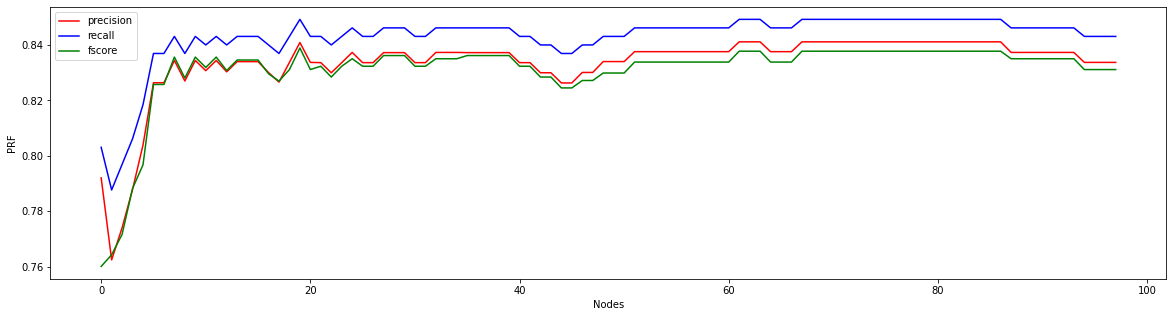

In [ ]:
plt.rcParams['figure.figsize']=(20,5)
fig, ax1 = plt.subplots()
ax1.plot(np.sort(np.arange(98))[::-1],precision, color = 'red')
ax1.plot(np.sort(np.arange(98))[::-1],recall, color = 'blue')
ax1.plot(np.sort(np.arange(98))[::-1],fscore, color = 'green')
ax1.set_xlabel('Nodes')
ax1.set_ylabel('PRF')
L=ax1.legend(['precision', 'recall', 'fscore' ]) #get the legend
